# TUTORIAL DEAP - Problema da fabricação de garrafas

Você gerencia uma fábrica de garrafas plásticas que tem apenas uma máquina extrusora. Esta máquina pode funcionar até 60 horas por semanda, isto é, 6 dias por semana com jornada de 10 horas por dia. A máquina é capaz de produzir dois tipos de garrafas plásticas: tipo "leite" e tipo "suco". Toda a produção semanal de garrafas plásticas é armazenada temporariamente num depósito. No domingo toda a produção é despachada para os compradores e o depósito é esvaziado completamente.  

A linha de produção leva 6 horas para produzir 100 garrafas tipo leite e 5 horas para produzir 100 garrafas tipo suco. Cada Carrafa tipo leite ocupa 10 unidades cúbicas de espaço no depósito, enquanto que a garrafa de tipo suco ocupa 20 unidades cúbicas. O depósito tem capacidade máxima de 15000 unidades cúbicas.  

A contribuição no lucro final da empresa por garrafa tipo leite é de 5 unidades monetárias e por garrafa tipo suco é de 4,5. O departamento de vendas tem contratos de fornecimento capazes de absorver toda a produção possível de garrafas tipo suco, porém tem compradores somente para 800 garrafastipo leite por semana.  

Você deve estabelecer qual é o plano de produção mais adequado para maximizar o lucro total da empresa, isto é, quantas garrafas tipo Leite e quantos tipoo Suco devem ser produzidas semanalmente.


### Import dos pacotes
O DEAP fornece várias bibliotecas que facilitam o trabalho e deverão ser importadas:  
- base: 
- creator:
- tools:
- algorithms:

Outras blibliotecas auxiliares serão utilizadas nesse tutorial:
- random:
- numpy:

In [1]:
import random
import numpy
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

# INIT
toolbox = base.Toolbox()

### Natureza do problema
Como se trata de um problema de maximização criamos essa função conforme a especificação do DEAP

In [2]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

### Individuos e população
Cada problema necessita uma forma particular de modelar o individuo, bem como a população deve ser gerada. Sendo assim os passos que devemos fazer no DEAP são:
- Definir estrutura do individuo(list, set, etc)
- Definir a função que irá gerar os alelos
- Definir a função que irá gerar os individuos
- Definir a função que irá gerar a popuulação

In [3]:
# Definindo a estrutura do indivíduo
IND_SIZE = 20  # Tamanho do individuo - 10 para cada gene
GENES = 2
creator.create("Individual", list, fitness=creator.FitnessMax)

# funcao para gerar o gene com alelos 0 ou 1 randomicamente uniforme
toolbox.register("attr_bool", random.randint, 0, 1)

# funcao para gerar o indivíduo (nome, forma de gerar, Estrutura, funcao geradora, tamanho)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=IND_SIZE)

# funcao para gerar a populacao
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

### Função de fitness
Essa função ao contrário das outras que são produzidas quase que parametricamente, deve ser impllementada manualmente. Nela é onde o individuo receberá o valor de fitness que corresponde à modelagem funcional do problem. Para o caso deste exemplo em questão temos:

In [4]:
# funcao de fitness
def evaluate(individual):
    l = int("".join(str(i) for i in individual[:int(IND_SIZE/GENES)]), 2)    # gene quantidade de garrafas de leite
    s = int("".join(str(i) for i in individual[int(IND_SIZE/GENES):]), 2)    # gene quantidade de garrafas de suco
    g = (5 * l + 4.5 * s) / 9718.5                                           # funcao objetivo normalizada [0,1]
    h1 = max(0, ((6 * l + 5 * s) / 100 - 60)) / 52.53                        # funcao de restricao 1 normalizada [0,1]
    h2 = max(0, (10 * l + 20 * s - 15000)) / 15690                           # funcao de restricao 2 normalizada [0,1]
    h3 = max(0, (l - 800)) / 223                                             # funcao de restricao 3 normalizada [0,1]
    h4 = max(0, (s - 750)) / 273                                             # funcao de restricao 4 normalizada [0,1]
    return g - 2*(h1+h2+h3+h4)/4,                                            # fitness normalizado [0,1]

### Operadores
Para o DEAP são considerados como operadores:
- evaluate: operador para realizar o cálculo de fitness do indivíduo
- mate: operador para realizar cross over de indivíduos
- mutate: operador para realizar a mutação dos 
- select: operador para selecionar os melhores de uma geração para outra  

Cada um desses operadores deve ser registrado. Seguindo a documentação do DEAP, damos um nome para o operador, seguido da função que ele irá realizar, seguido dos parametros dessa função

In [5]:
# registra funcao de fitness
toolbox.register("evaluate", evaluate)

# registra crossOver
toolbox.register("mate", tools.cxTwoPoint)

# registra mutacao com probabilidade default de mudar cada gene de 5%
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

# registra o metodo de selecao como torneio de tamanho 3
toolbox.register("select", tools.selTournament, tournsize=3)

### Funções adicionais
Dependendo de cada caso, podemos desejar mostrar relatórios específicos. Para esse problema, criamos duas funçõs. Uma para imprimir os dados de um indivíduo e outra para plotar o gráfico das evoluções das gerações.


In [6]:
#Imprimir indivíduo
def print_ind(individual):
    l = int("".join(str(i) for i in individual[:int(IND_SIZE / GENES)]), 2)  # gene quantidade de garrafas de leite
    s = int("".join(str(i) for i in individual[int(IND_SIZE / GENES):]), 2)  # gene quantidade de garrafas de suco
    g = 5*l + 4.5*s
    print('Individuo:' + str(individual))
    print('Quantidade de garrafas de leite: ' + str(l))
    print('Quantidade de garrafas de suco: ' + str(s))
    print('Lucro: ' + str(g))

#Plotar Gráfico
def plot_log(logbook):
    gen = logbook.select("gen")
    min = logbook.select("min")
    avg = logbook.select("avg")
    max = logbook.select("max")

    import matplotlib.pyplot as plt

    fig, ax1 = plt.subplots()
    line1 = ax1.plot(gen, min, "b-", label="Minimum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")

    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, avg, "g-", label="Average Fitness")
    for tl in ax2.get_yticklabels():
        tl.set_color("g")

    ax3 = ax1.twinx()
    line3 = ax3.plot(gen, max, "y-", label="Maximum Fitness")
    ax3.set_ylabel("Size")
    for tl in ax3.get_yticklabels():
        tl.set_color("y")

    lns = line1 + line2 + line3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="center right")

    plt.show()

### Algoritmo
Depois de definir toda a estrutura do nosso problema e o comportamento, faz-se necessário implementar o algoritmo que irá rodar. Essa implementação é composta dos parametros do Algoritmo Genético e a logica que manipula a população.

No exemplo abaixo utilizamos uma implementação já fornecida pelo DEAP: o eaSimple que é um algoritmos do livro “Evolutionary Computation 1 : Basic Algorithms and Operators”(cap.7). Neste exemplo também optei poro trazer uma implementação mais enxuta sem mostrar os stats monitorados no console, de modo apenas focarmos no processo como um todo do AG.

gen	nevals	std     	min      	avg     	max   
0  	70    	0.279164	-0.794191	0.222211	0.5251
1  	53    	0.137051	-0.182224	0.365127	0.521669
2  	57    	0.104841	-0.18801 	0.433291	0.527247
3  	62    	0.0855094	-0.102859	0.466715	0.5277  
4  	61    	0.0348315	0.347647 	0.498005	0.527777
5  	58    	0.0463223	0.270386 	0.501738	0.527926
6  	52    	0.0528416	0.130146 	0.498091	0.527926
7  	50    	0.169755 	-0.666382	0.48663 	0.527952
8  	44    	0.0118609	0.458677 	0.524036	0.527952
9  	58    	0.0480039	0.144649 	0.519095	0.527978
10 	61    	0.0011975	0.523538 	0.527375	0.527978
11 	58    	0.000187768	0.527242 	0.527867	0.527978
12 	60    	0.00671136 	0.476925 	0.52684 	0.527978
13 	58    	1.28367e-05	0.527926 	0.527958	0.527978
14 	50    	0.000147406	0.527242 	0.527935	0.527978
15 	62    	1.45458e-05	0.527864 	0.527974	0.527978
16 	46    	1.11022e-16	0.527978 	0.527978	0.527978
17 	53    	1.11022e-16	0.527978 	0.527978	0.527978
18 	58    	5.37505e-05	0.527525 	0.527971	0.527978
19 	52    	0

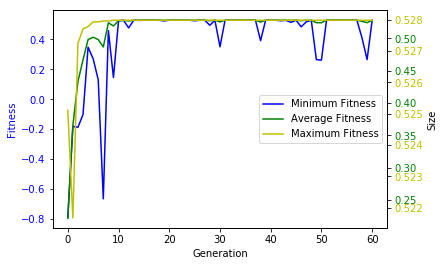

In [7]:
def main():
    random.seed(94)

    # cria populacao inicial
    pop = toolbox.population(n=70)

    # CXPB - probabilidade de crossover
    # MUTPB - probabilidade de mutacao
    # NGEN - numero de geracoes
    CXPB, MUTPB, NGEN =0.8, 0.02, 60
    
    #stats a serem guardados
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("avg", numpy.mean)
    stats.register("max", numpy.max)

    #Roda o algoritmo
    pop, logbook = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats=stats)

    #Seleciona o melhor individuo da populacao resultante
    best_ind = tools.selSPEA2(pop, 1)

    #Imprime as infromações do melhor individuo
    print_ind(best_ind[0])

    #Plota o Gráfico
    plot_log(logbook)


if __name__ == "__main__":
    main()